In [1]:
import sys
from pathlib import Path
curr_path = str(Path().absolute())
parent_path = str(Path().absolute().parent)
sys.path.append(parent_path) # add current terminal path to sys.path

In [2]:
import gym
import torch
import datetime
from PPO.agent import PPO
from common.plot import plot_rewards
from common.utils import save_results,make_dir

curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # obtain current time

In [3]:
class PPOConfig:
    def __init__(self) -> None:
        self.env = 'CartPole-v0'
        self.algo = 'PPO'
        self.result_path = curr_path+"/results/" +self.env+'/'+curr_time+'/results/'  # path to save results
        self.model_path = curr_path+"/results/" +self.env+'/'+curr_time+'/models/'  # path to save models
        self.train_eps = 200 # max training episodes
        self.test_eps = 50
        self.batch_size = 5
        self.gamma=0.99
        self.n_epochs = 4
        self.actor_lr = 0.0003
        self.critic_lr = 0.0003
        self.gae_lambda=0.95
        self.policy_clip=0.2
        self.hidden_dim = 256
        self.update_fre = 20 # frequency of agent update
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # check gpu

In [4]:
def env_agent_config(cfg,seed=1):
    env = gym.make(cfg.env)  
    env.seed(seed)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = PPO(state_dim,action_dim,cfg)
    return env,agent

In [5]:
def train(cfg,env,agent):
    print('Start to train !')
    print(f'Env:{cfg.env}, Algorithm:{cfg.algo}, Device:{cfg.device}')
    rewards= []
    ma_rewards = [] # moving average rewards
    running_steps = 0
    for i_ep in range(cfg.train_eps):
        state = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action, prob, val = agent.choose_action(state)
            state_, reward, done, _ = env.step(action)
            running_steps += 1
            ep_reward += reward
            agent.memory.push(state, action, prob, val, reward, done)
            if running_steps % cfg.update_fre == 0:
                agent.update()
            state = state_
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(
                0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep+1)%10==0:
            print(f"Episode:{i_ep+1}/{cfg.train_eps}, Reward:{ep_reward:.3f}")
    print('Complete training！')
    return rewards,ma_rewards

In [6]:
def eval(cfg,env,agent):
    print('Start to eval !')
    print(f'Env:{cfg.env}, Algorithm:{cfg.algo}, Device:{cfg.device}')
    rewards= []
    ma_rewards = [] # moving average rewards
    for i_ep in range(cfg.test_eps):
        state = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action, prob, val = agent.choose_action(state)
            state_, reward, done, _ = env.step(action)
            ep_reward += reward
            state = state_
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(
                0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep+1)%10==0:
            print(f"Episode:{i_ep+1}/{cfg.train_eps}, Reward:{ep_reward:.3f}")
    print('Complete evaling！')
    return rewards,ma_rewards

Start to train !
Env:CartPole-v0, Algorithm:PPO, Device:cuda
Episode:10/200, Reward:15.000
Episode:20/200, Reward:9.000
Episode:30/200, Reward:20.000
Episode:40/200, Reward:17.000
Episode:50/200, Reward:64.000
Episode:60/200, Reward:90.000
Episode:70/200, Reward:23.000
Episode:80/200, Reward:138.000
Episode:90/200, Reward:150.000
Episode:100/200, Reward:200.000
Episode:110/200, Reward:200.000
Episode:120/200, Reward:200.000
Episode:130/200, Reward:200.000
Episode:140/200, Reward:200.000
Episode:150/200, Reward:200.000
Episode:160/200, Reward:200.000
Episode:170/200, Reward:200.000
Episode:180/200, Reward:200.000
Episode:190/200, Reward:200.000
Episode:200/200, Reward:200.000
Complete training！
results saved!


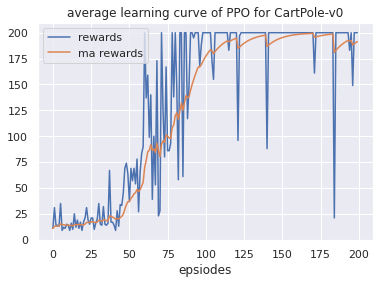

Start to eval !
Env:CartPole-v0, Algorithm:PPO, Device:cuda
Episode:10/200, Reward:200.000
Episode:20/200, Reward:183.000
Episode:30/200, Reward:157.000
Episode:40/200, Reward:200.000
Episode:50/200, Reward:113.000
Complete evaling！
results saved!


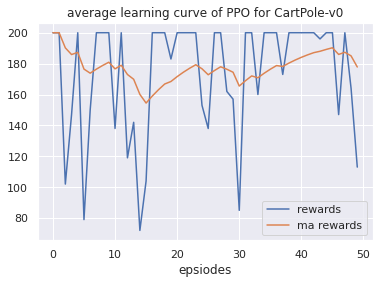

In [7]:
if __name__ == '__main__':
    cfg  = PPOConfig()
    # train
    env,agent = env_agent_config(cfg,seed=1)
    rewards, ma_rewards = train(cfg, env, agent)
    make_dir(cfg.result_path, cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(rewards, ma_rewards, tag='train', path=cfg.result_path)
    plot_rewards(rewards, ma_rewards, tag="train",
                 algo=cfg.algo, path=cfg.result_path)
    # eval
    env,agent = env_agent_config(cfg,seed=10)
    agent.load(path=cfg.model_path)
    rewards,ma_rewards = eval(cfg,env,agent)
    save_results(rewards,ma_rewards,tag='eval',path=cfg.result_path)
    plot_rewards(rewards,ma_rewards,tag="eval",env=cfg.env,algo = cfg.algo,path=cfg.result_path)